# Milestone 4

**Sara Elkilany, Eyad Elsafoury, Aoi Otani, and Yesake Teshale**<br/>
**Fall 2023**<br/>
**Gun Violence in the US** <br/>
<hr style='height:2px'>

<a id="contents"></a>

## Notebook contents

- [**Problem Statement**](#part1)
  - [Motivation](#part1.1)
  - [EDA](#part1.2)
  - [Objective](#part1.3)
      
- [**Model Implementation**](#part2)
  - [Data Overview](#part2data)
  - [Decision Tree](#part2.1)
  - [Bagging](#part2.2)
  - [Random Forest](#part2.3)
  - [Final Model](#part2final)

<a id="part1"></a>
    
# Problem Statement

<a id="part1.1"></a>
## Motivation 

Gun violence remains a pressing issue in the United States, with a significant impact on public safety, health, and community well-being. Every year, thousands of individuals fall victim to gun-related incidents, ranging from mass shootings to individual crimes. This epidemic of violence not only leads to loss of life but also instills fear and long-term trauma in communities. Some of our group members have experienced this impact firsthand, living in cities with high rates of gun violence and having suffered personal losses due to such incidents. This personal connection to the issue deepens our commitment to finding solutions.  
Understanding the patterns and predictors of such incidents can play a crucial role in prevention and response strategies. Data science offers a unique opportunity in this context, enabling the analysis of extensive datasets to uncover crucial insights into the nature of gun violence. By exploring data on past incidents, we can identify patterns and trends that might otherwise remain obscured, offering a new perspective on a problem that continues to challenge policymakers, law enforcement agencies, and communities.
The challenge in addressing gun violence lies not only in the sheer volume of incidents but also in the complexity and variability of each case. Factors such as the perpetrator's age and gender, the nature of the crime, and the context of the incident all play critical roles. Traditional analytical methods may fall short in capturing the nuanced interplay of these variables. Thus, there's a pressing need for innovative approaches that can analyze large datasets, identify patterns, and provide actionable insights. This is where machine learning models come into play, offering the ability to process and analyze data at a scale and depth that is beyond human capacity.

<a id="part1.2"></a>
## EDA

In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css").text
HTML(styles)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
df = pd.read_csv("data.csv")
data = df.copy()
missing_values = data.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0]
print(columns_with_missing_values)

# Filter rows where 'Victim_average_age' is missing
missing_age_df = df[df['Victim_average_age'].isnull()]

# Save these rows to a new CSV file
# missing_age_df.to_csv('missing_victim_age.csv', index=False)

filtered_rows = df[df['Victim_average_age'].isnull() & (df['n_injured'] == 0) & (df['n_killed'] == 0)]

# Count these rows
count_filtered_rows = filtered_rows.shape[0]

# These are possession charges, or cases where there are no victims. Therefore they are not needed for our model 
print("Number of rows with no injuries or deaths and missing Victim_average_age:", count_filtered_rows)
# filtered_rows.to_csv('filtered_data.csv', index=False)


gun_stolen                  19428
gun_type                    19423
incident_characteristics       54
latitude                        4
location_description        50953
longitude                       4
n_guns_involved             19423
notes                       19577
participant_age_group          46
participant_name             5082
participant_relationship    53701
participant_status            214
state_house_district         7496
state_senate_district        5568
Victim_average_age          39883
dtype: int64
Number of rows with no injuries or deaths and missing Victim_average_age: 29091


### check if participate age group is child, teen, adult and input the average of of that age group accordingly (remove the ones that dont have victims age group.)

In [30]:
# Calulate the average age of the three different age groups. 
count = 0
helper = pd.read_csv("stage3.csv")
def extract_victim_average_age_groups(df):
    # Dictionaries to hold the ages of 'Victim' for different age groups
    victim_ages_groups = {'0-12': [], '12-18': [], '18+': []}

    for _, row in df.iterrows():
        participant_type = row['participant_type']
        participant_age = row['participant_age']

        if isinstance(participant_type, str) and isinstance(participant_age, str):
            # Split the strings into lists
            types = participant_type.split("||")
            ages = participant_age.split("||")

            # Dictionary to hold index and type
            type_dict = {}
            for t in types:
                parts = t.split("::")
                if len(parts) == 2:
                    index, type = parts
                    type_dict[index] = type

            for index, type in type_dict.items():
                if type == "Victim":
                    for age in ages:
                        age_parts = age.split("::")
                        if len(age_parts) == 2 and age_parts[0] == index:
                            try:
                                age_value = int(age_parts[1])
                                if age_value <= 12:
                                    victim_ages_groups['0-12'].append(age_value)
                                elif 12 < age_value <= 18:
                                    victim_ages_groups['12-18'].append(age_value)
                                else:
                                    victim_ages_groups['18+'].append(age_value)
                            except ValueError:
                                # Handle cases where age is not a number
                                continue

    # Calculate the average age for each group
    averages = []
    for group in ['0-12', '12-18', '18+']:
        group_ages = victim_ages_groups[group]
        if group_ages:
            average_age = sum(group_ages) / len(group_ages)
            averages.append(average_age)
        else:
            averages.append(None)  # None indicates no data for this age group

    return averages
    
average_ages = extract_victim_average_age_groups(helper)

print("Average ages for the groups 0-12, 12-18, 18+ are:", average_ages)



Average ages for the groups 0-12, 12-18, 18+ are: [6.462905500705219, 16.471141484538872, 32.904180461253574]


Now that we have these values, for instances with missing "victim_average_age" we will add these values. If there are multiple victimes, we will do the average.

In [5]:
count = 0
def update_victim_average_age(df, age_group_averages):
    for i, row in df.iterrows():
        if pd.isnull(row['Victim_average_age']):
            participant_type = row['participant_type']
            participant_age = row['participant_age']

            if isinstance(participant_type, str) and isinstance(participant_age, str):
                types = participant_type.split("||")
                ages = participant_age.split("||")

                victim_ages = []
                for t, age in zip(types, ages):
                    if 'Victim' in t:
                        age_parts = age.split("::")
                        if len(age_parts) == 2:
                            try:
                                age_value = str(age_parts[1])
                                if age_value == "Child 0-11":
                                    victim_ages.append(age_group_averages[0])
                                elif age_value == "Teen 12-17":
                                    victim_ages.append(age_group_averages[1])
                                else:
                                    victim_ages.append(age_group_averages[2])
                            except ValueError:
                                continue

                if victim_ages:
                    df.at[i, 'Victim_average_age'] = sum(victim_ages) / len(victim_ages)

    return df


age_group_averages = [6.462905500705219, 16.471141484538872, 32.904180461253574]
mean_imput_df = data.copy()
# Impute the victim age for the victime we have some information about (participate age_group) 
updated_df = update_victim_average_age(mean_imput_df, age_group_averages)


In [6]:
missing_values_count = updated_df['Victim_average_age'].isna().sum()
print(f"Number of missing values in 'Victim_average_age': {missing_values_count}")

# 9000 values are imputed using mean of the victims age group and the rest are dropped 
# gives us an extra 9k datapoints rather than the 19k we trained on
df_mean_drop = updated_df.dropna(subset=['Victim_average_age'])

# 9000 values are imputed but there are still 30,000 missing values. There is now an indicator varible though
df_mean_indictor = updated_df.copy()
df_mean_indictor['Victim_average_age_missing'] = df_mean_indictor['Victim_average_age'].isnull().astype(int)


all_drop = data.copy()

all_drop = all_drop.dropna(subset=['Victim_average_age'])



Number of missing values in 'Victim_average_age': 30260


In [7]:
[len(all_drop),
len(df_mean_indictor),
len(df_mean_drop),len(data)]

[21778, 61661, 31401, 61661]

Missing Data indicator

First let's handle the age group, our target variable. Let's look at the distribution of the data:

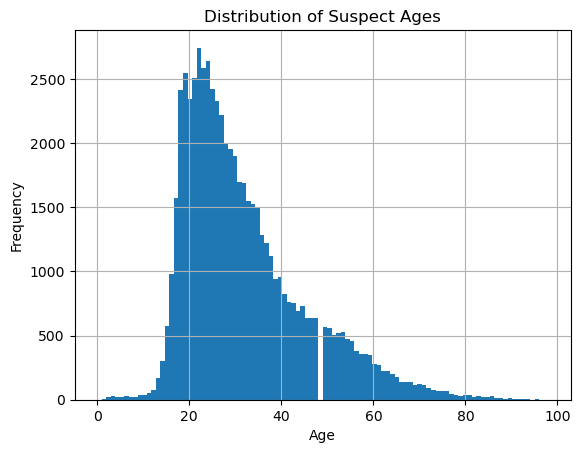

Age Group Cut-offs: [0, 12, 20, 44, 64, 100]


In [8]:
df['Subject-Suspect_age'].hist(bins=100)  # You can adjust the number of bins
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Suspect Ages')
plt.show()

# Define your custom bins
custom_bins = [0,12,20,44,64, 100]

# Create age groups based on custom bins
data['Age_Group_Code'] = pd.cut(data['Subject-Suspect_age'], bins=custom_bins, labels=False, right=False)

# Print the cut-offs for the age groups
print("Age Group Cut-offs:", custom_bins)

The decision to group suspect ages into specific bins was driven by the need to simplify the analysis and enhance the interpretability of our model. By examining the histogram of suspect ages, it became evident that the distribution of ages was not uniform, warranting a categorization approach. The custom age bins [0-12, 12-20, 20-44, 44-64, 64-100] were chosen based on logical age groupings that reflect distinct life stages, which are likely to have different behavioral patterns and motivations. This categorization facilitates a more focused analysis and can help in identifying specific age groups that are more prominently represented in gun violence incidents, thereby informing targeted intervention strategies.  
- **Children (0-12 years):** This category includes individuals from infancy to pre-adolescence. In the context of gun violence incidents, this age group is typically considered as victims rather than perpetrators.  
  
- **Teenagers (13-20 years):** This group encompasses individuals in their teenage years. It's a critical stage where early signs of deviant behavior might emerge, and understanding patterns here can be key to early intervention strategies.  

- **Young Adults (21-44 years):** This age bracket includes individuals who are in the prime of their adult life. It's a diverse group where the majority of gun violence perpetrators fall, making it a focal point for detailed analysis and preventive measures.  

- **Middle-Aged Adults (45-64 years):** This category includes individuals who are in the middle age range. Their involvement in gun violence incidents may differ significantly in motives and patterns compared to younger groups.  

- **Senior Adults (65 years and above):** This group includes older adults, where involvement in gun violence incidents is relatively rare but still significant to study for a comprehensive understanding of the issue.  

Before we begin exploring, we have to clean our data enough to realistically tackle this problem. This means we have to remove the columns that provide information that would not be feasible to have if the suspect was unknown. For example, the columns depicting the relationship among the suspect and victim, as well as the columns describing the gun. This is all informartion that would not be known. 

In [9]:
columns_to_remove = ["Unnamed: 0","incident_id","date","gun_stolen","gun_type","participant_status",
                     "location_description","notes","participant_age", "participant_gender", 
                     "participant_name","participant_relationship","latitude","longitude",
                     "n_guns_involved","incident_characteristics", "state_senate_district", 
                     "Subject-Suspect_age","Subject-Suspect_gender","arrested_count", 
                     "participant_type","participant_age_group"]
data = data.drop(columns=columns_to_remove)

In [10]:
data.head()

,state,city_or_county,n_killed,n_injured,congressional_district,state_house_district,Victim_average_age,Age_Group_in_10s,Subject-Suspect_gender_binary,year,month,Age_Group_Code
0,New York,Queens,1,0,5.0,33.0,22.0,20-30,1,2014,1,2
1,Georgia,Columbus,0,1,2.0,135.0,27.0,20-30,1,2014,1,2
2,Georgia,Bibb County,0,1,2.0,142.0,24.0,30-40,1,2014,1,2
3,Virginia,Prince William County,0,1,1.0,50.0,31.0,20-30,1,2014,1,2
4,Virginia,Hampton,0,0,3.0,92.0,19.0,10-20,1,2014,1,1


The dataset provides a lot of information regarding location. We had originally decided to use congressional district, but we are open to trying other measures if that proves to be unhelpful. Now let's look at the data types:

In [11]:
print(f"Our data contains {len(data):,} samples.")

print("DATA INFORMATION:\n")
data.info()

print("\n SUMMARY STATISTICS:")
display(data.describe())

Our data contains 61,661 samples.
DATA INFORMATION:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61661 entries, 0 to 61660
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          61661 non-null  object 
 1   city_or_county                 61661 non-null  object 
 2   n_killed                       61661 non-null  int64  
 3   n_injured                      61661 non-null  int64  
 4   congressional_district         61661 non-null  float64
 5   state_house_district           54165 non-null  float64
 6   Victim_average_age             21778 non-null  float64
 7   Age_Group_in_10s               61661 non-null  object 
 8   Subject-Suspect_gender_binary  61661 non-null  int64  
 9   year                           61661 non-null  int64  
 10  month                          61661 non-null  int64  
 11  Age_Group_Code                 61661 non-null  int64 

,n_killed,n_injured,congressional_district,state_house_district,Victim_average_age,Subject-Suspect_gender_binary,year,month,Age_Group_Code
count,61661.000000,61661.000000,61661.000000,54165.000000,21778.000000,61661.000000,61661.000000,61661.000000,61661.000000
mean,0.340377,0.315256,7.857787,56.604652,32.783284,0.946190,2015.788700,6.252737,2.062941
std,0.650758,0.661762,8.150874,43.988453,15.410797,0.225645,1.186091,3.460100,0.654394
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2014.000000,1.000000,0.000000
25%,0.000000,0.000000,2.000000,23.000000,22.000000,1.000000,2015.000000,3.000000,2.000000
50%,0.000000,0.000000,5.000000,49.000000,29.000000,1.000000,2016.000000,6.000000,2.000000
75%,1.000000,1.000000,10.000000,84.000000,41.000000,1.000000,2017.000000,9.000000,2.000000
max,50.000000,53.000000,53.000000,814.000000,99.000000,1.000000,2018.000000,12.000000,4.000000


The data set contains some variables that we need to convert to categorical to ensure that an order isn't applied to them:

In [12]:
data['congressional_district'] = data['congressional_district'].astype('category')
data['state_house_district	'] = data['state_house_district'].astype('category')

Now, let's get familiar with incidents and how they relate to the variables in our dataset:

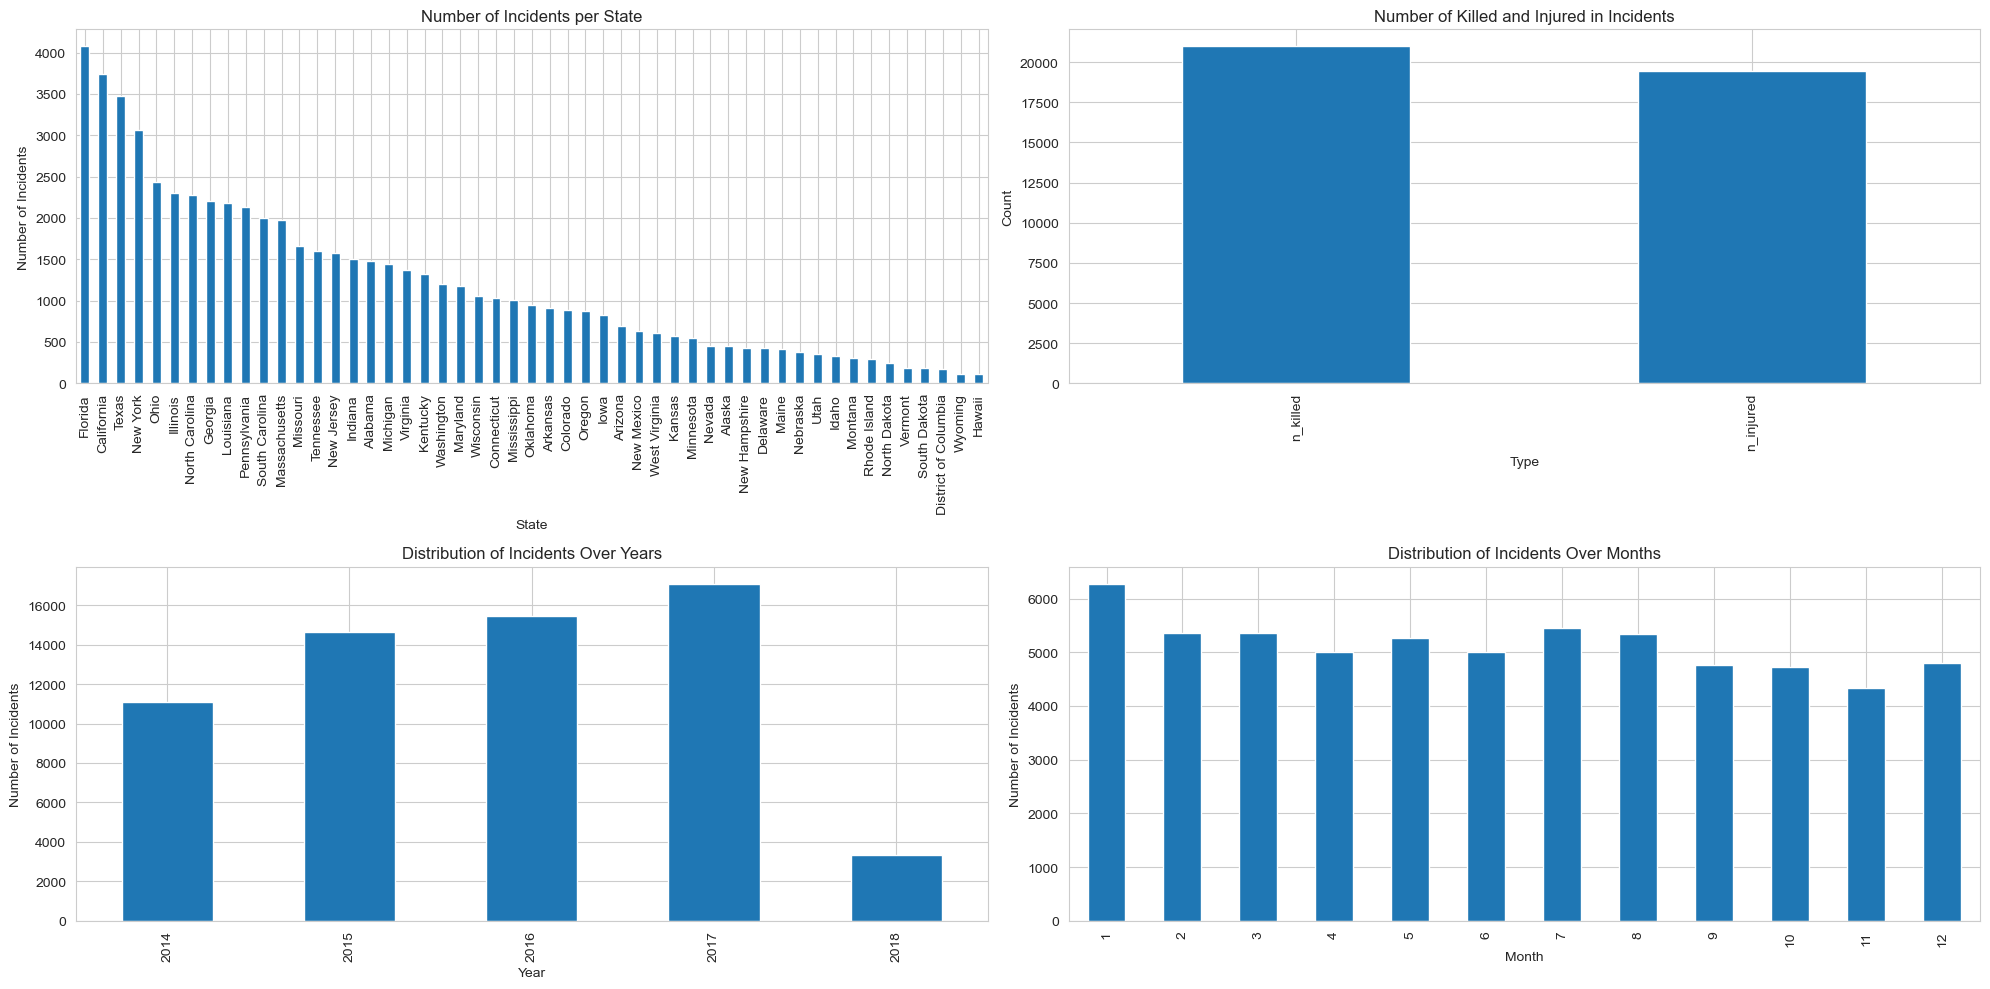

In [13]:
sns.set_style("whitegrid")

# 1. Number of incidents per state
state_counts = data['state'].value_counts()

# 2. Number of killed and injured in incidents
n_killed_injured = data[['n_killed', 'n_injured']].sum()

# 3. Distribution of incidents over the years
year_counts = data['year'].value_counts().sort_index()

# 4. Distribution of incidents over months
month_counts = data['month'].value_counts().sort_index()

plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
state_counts.plot(kind='bar')
plt.title('Number of Incidents per State')
plt.xlabel('State')
plt.ylabel('Number of Incidents')

plt.subplot(2, 2, 2)
n_killed_injured.plot(kind='bar')
plt.title('Number of Killed and Injured in Incidents')
plt.xlabel('Type')
plt.ylabel('Count')

plt.subplot(2, 2, 3)
year_counts.plot(kind='bar')
plt.title('Distribution of Incidents Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')

plt.subplot(2, 2, 4)
month_counts.plot(kind='bar')
plt.title('Distribution of Incidents Over Months')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')

plt.tight_layout()
plt.show()

From the first graph on the left, we see that incidents vary drastically by state, with Florida having the highest number of incidents. This is something to potentially keep in mind when implementing the model. In the first graph on the right, we observe that our two numerical variables are relatively balanced.  

In the Incidents vs. Year graph on the bottom right, we notice a general trend towards increasing gun accidents (note that 2018 only contains three months and is thus truncated). From the last graph, we observe that the distribution of incidents over the twelve months is relatively evenly spread.

Subject-Suspect_gender_binary   -0.055648
n_injured                       -0.026356
state_house_district            -0.013630
year                            -0.006193
month                           -0.002231
n_killed                         0.100566
Victim_average_age               0.321509
Age_Group_in_10s_encoded         1.000000
Name: Age_Group_in_10s_encoded, dtype: float64


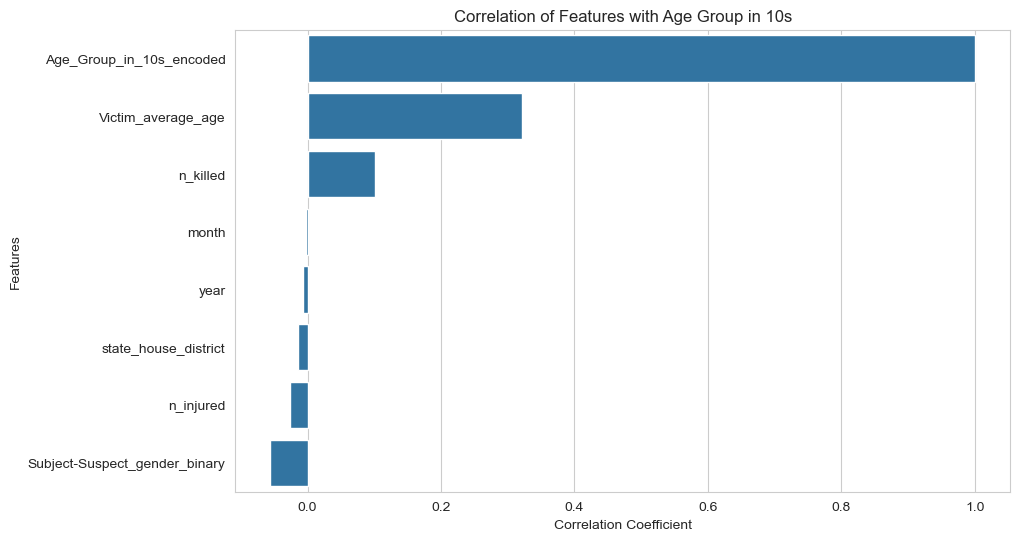

In [14]:
data_copy = data.copy()

age_group_mapping = {group: i for i, group in enumerate(data_copy['Age_Group_in_10s'].unique())}
data_copy['Age_Group_in_10s_encoded'] = data_copy['Age_Group_in_10s'].map(age_group_mapping)

numeric_df = data_copy.select_dtypes(include=[np.number])
numeric_df = numeric_df.drop('Age_Group_Code', axis=1)
correlation_with_age_group = numeric_df.corr()['Age_Group_in_10s_encoded'].sort_values()

# Displaying the updated correlation coefficients
print(correlation_with_age_group)

# Adjusting the DataFrame for better visualization of the correlation coefficients
correlation_df = pd.DataFrame(correlation_with_age_group).reset_index()
correlation_df.columns = ['Feature', 'Correlation with Age Group in 10s']
correlation_df = correlation_df.dropna().sort_values(by='Correlation with Age Group in 10s', ascending=False)

# Plotting the improved correlation plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Correlation with Age Group in 10s', y='Feature', data=correlation_df)
plt.title('Correlation of Features with Age Group in 10s')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

The examination of feature correlation with the target variable reveals that the 'Victim_Average_Age' exhibits the highest correlation, indicating its heightened significance in predicting the target outcome. This implies a notable association, suggesting that incidents with elevated victim ages tend to involve older suspects. A similar, albeit less pronounced, correlation is observed for the number of people killed. Additionally, the analysis indicates a positive correlation between the suspect being female and an increased age of the suspect, further contributing to the nuanced understanding of the dataset.

Now we can explore the class imbalance for each of the features.

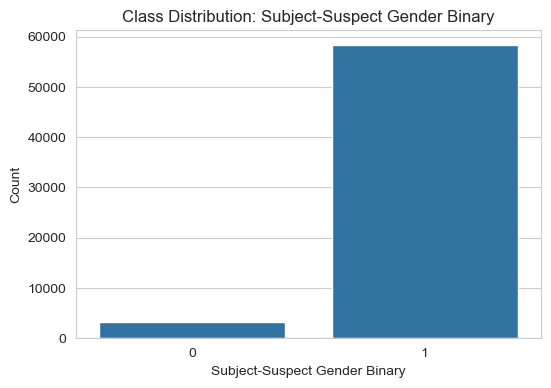

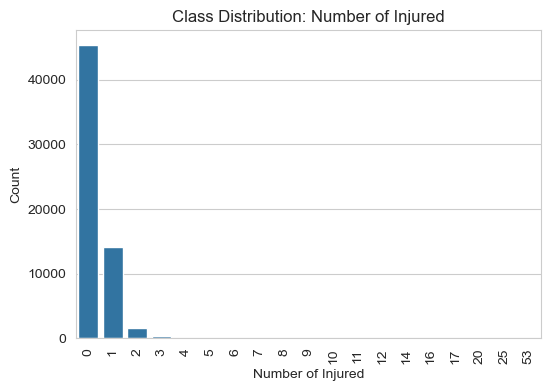

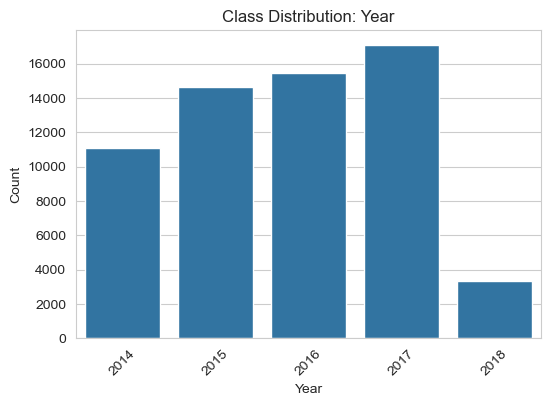

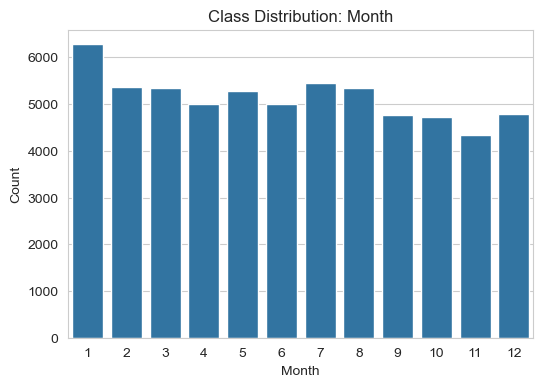

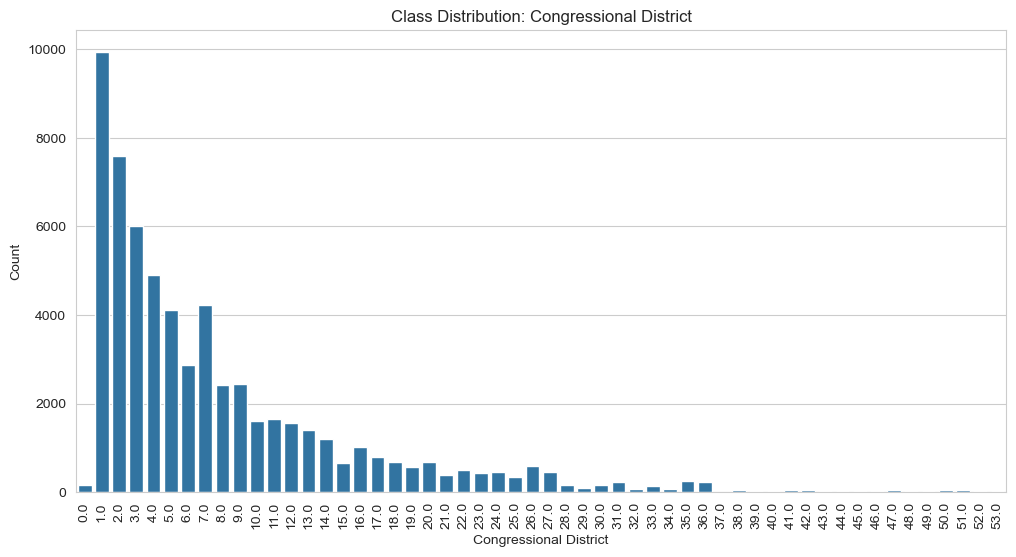

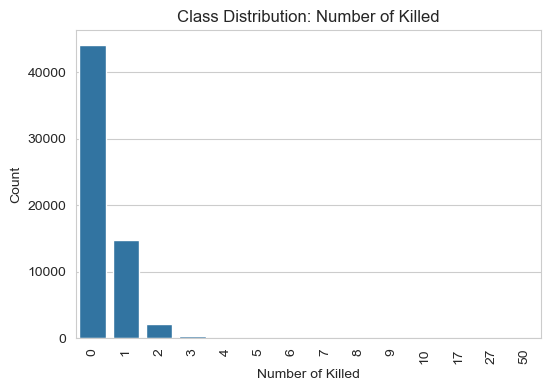

In [15]:
# Feature 1: Subject-Suspect_gender_binary
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Subject-Suspect_gender_binary')
plt.title('Class Distribution: Subject-Suspect Gender Binary')
plt.xlabel('Subject-Suspect Gender Binary')
plt.ylabel('Count')
plt.show()

# Feature 2: n_injured
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='n_injured')
plt.title('Class Distribution: Number of Injured')
plt.xlabel('Number of Injured')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# Feature 4: year
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='year')
plt.title('Class Distribution: Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Feature 5: month
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='month')
plt.title('Class Distribution: Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

# Feature 6: congressional_district
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='congressional_district')
plt.title('Class Distribution: Congressional District')
plt.xlabel('Congressional District')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# Feature 7: n_killed
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='n_killed')
plt.title('Class Distribution: Number of Killed')
plt.xlabel('Number of Killed')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Evidently, a substantial data imbalance exists among genders, prompting our decision to exclusively predict suspect age rather than both age and gender. This choice was driven by the recognition that the inherent data imbalance would pose considerable challenges. Notably, in the context of both the number of injured and the number killed, the data distribution is skewed toward values of 0 or 1, aligning with the inherent characteristics of gun violence incidents. While this distribution should not unduly impact our analyses, it necessitates a vigilant consideration of potential outliers. The remaining variables exhibit a balanced distribution.

Now, to prepare our data for model implementation. we need to convert the followif categorical variables: 'Age_Group_in_10s', 'state', and 'city_or_county'.

In [16]:
# Perform one-hot encoding for the 'state' column
df_encoded = pd.get_dummies(data, columns=['state'])

# Calculate the frequency of each city or county
city_freq = df_encoded['city_or_county'].value_counts().to_dict()

# Map frequencies to the 'city_or_county' column
df_encoded['city_or_county_freq'] = df_encoded['city_or_county'].map(city_freq)

# drop columns but recognize city later
columns_to_drop = ["city_or_county", "Age_Group_in_10s"]
df = df_encoded.drop(columns=columns_to_drop)

# rename gender column
df.rename(columns={'Subject-Suspect_gender_binary': 'gender'})

,n_killed,n_injured,congressional_district,state_house_district,Victim_average_age,gender,year,month,Age_Group_Code,state_house_district\t,...,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,city_or_county_freq
0,1,0,5.0,33.0,22.0,1,2014,1,2,33.0,...,False,False,False,False,False,False,False,False,False,37
1,0,1,2.0,135.0,27.0,1,2014,1,2,135.0,...,False,False,False,False,False,False,False,False,False,444
2,0,1,2.0,142.0,24.0,1,2014,1,2,142.0,...,False,False,False,False,False,False,False,False,False,6
3,0,1,1.0,50.0,31.0,1,2014,1,2,50.0,...,False,False,False,False,True,False,False,False,False,1
4,0,0,3.0,92.0,19.0,1,2014,1,1,92.0,...,False,False,False,False,True,False,False,False,False,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61656,0,1,8.0,114.0,63.0,1,2018,3,2,114.0,...,False,False,False,False,False,False,False,False,False,2
61657,0,1,9.0,90.0,69.0,0,2018,3,2,90.0,...,True,False,False,False,False,False,False,False,False,330
61658,0,0,5.0,4.0,NaN,1,2018,3,3,4.0,...,False,False,False,False,False,True,False,False,False,23
61659,1,0,4.0,23.0,NaN,1,2018,3,2,23.0,...,False,False,False,False,False,False,False,False,False,22


<a id="part1.3"></a>
## Objective

The overarching goal of this project is to develop a sophisticated machine learning model that accurately classifies the age group of perpetrators in gun violence incidents, utilizing a dataset encompassing various incident attributes. To achieve this, we will employ advanced predictive analytics techniques, focusing on classification algorithms known for their efficacy in handling multi-dimensional data. Our approach includes the preprocessing of the dataset for feature selection and engineering, ensuring that only the most relevant and influential predictors are utilized in the model. We will leverage algorithms such as Decision Trees, Random Forest and Bagging Classifiers, recognized for their robustness in handling imbalanced datasets and their capacity for feature importance evaluation. These models will be rigorously trained, validated, and tested using a split of the dataset to ensure accuracy and generalizability. Hyperparameter tuning will be conducted through methods like grid search to optimize the model's performance. The effectiveness of the model will be assessed using metrics like accuracy, which are critical for evaluating classification models. By integrating these data science methodologies, the project aims to provide a nuanced understanding of perpetrator age group in gun violence incidents across the United States, offering valuable insights for strategic decision-making in law enforcement and public safety initiatives.

<a id="part2"></a>
# Model Implementation

<a id="part2data"></a>
## Data Overview

In [17]:
print(f"Our data contains {len(df):,} samples.")

print("DATA INFORMATION:\n")
df.info()

print("\n DATA HEAD:")
display(df.head())

print("\n SUMMARY STATISTICS:")
display(df.describe())

Our data contains 61,661 samples.
DATA INFORMATION:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61661 entries, 0 to 61660
Data columns (total 62 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   n_killed                       61661 non-null  int64   
 1   n_injured                      61661 non-null  int64   
 2   congressional_district         61661 non-null  category
 3   state_house_district           54165 non-null  float64 
 4   Victim_average_age             21778 non-null  float64 
 5   Subject-Suspect_gender_binary  61661 non-null  int64   
 6   year                           61661 non-null  int64   
 7   month                          61661 non-null  int64   
 8   Age_Group_Code                 61661 non-null  int64   
 9   state_house_district	          54165 non-null  category
 10  state_Alabama                  61661 non-null  bool    
 11  state_Alaska                   61661 non

,n_killed,n_injured,congressional_district,state_house_district,Victim_average_age,Subject-Suspect_gender_binary,year,month,Age_Group_Code,state_house_district\t,...,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,city_or_county_freq
0,1,0,5.0,33.0,22.0,1,2014,1,2,33.0,...,False,False,False,False,False,False,False,False,False,37
1,0,1,2.0,135.0,27.0,1,2014,1,2,135.0,...,False,False,False,False,False,False,False,False,False,444
2,0,1,2.0,142.0,24.0,1,2014,1,2,142.0,...,False,False,False,False,False,False,False,False,False,6
3,0,1,1.0,50.0,31.0,1,2014,1,2,50.0,...,False,False,False,False,True,False,False,False,False,1
4,0,0,3.0,92.0,19.0,1,2014,1,1,92.0,...,False,False,False,False,True,False,False,False,False,86



 SUMMARY STATISTICS:


,n_killed,n_injured,state_house_district,Victim_average_age,Subject-Suspect_gender_binary,year,month,Age_Group_Code,city_or_county_freq
count,61661.000000,61661.000000,54165.000000,21778.000000,61661.000000,61661.000000,61661.000000,61661.000000,61661.000000
mean,0.340377,0.315256,56.604652,32.783284,0.946190,2015.788700,6.252737,2.062941,109.625420
std,0.650758,0.661762,43.988453,15.410797,0.225645,1.186091,3.460100,0.654394,146.528985
min,0.000000,0.000000,1.000000,0.000000,0.000000,2014.000000,1.000000,0.000000,1.000000
25%,0.000000,0.000000,23.000000,22.000000,1.000000,2015.000000,3.000000,2.000000,8.000000
50%,0.000000,0.000000,49.000000,29.000000,1.000000,2016.000000,6.000000,2.000000,45.000000
75%,1.000000,1.000000,84.000000,41.000000,1.000000,2017.000000,9.000000,2.000000,167.000000
max,50.000000,53.000000,814.000000,99.000000,1.000000,2018.000000,12.000000,4.000000,690.000000


Now we can split our train and test data.

In [18]:
X = df.drop('Age_Group_Code', axis=1)  # Features
y = df['Age_Group_Code']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)
X_train_copy, X_test_copy, y_train_copy, y_test_copy = X_train, X_test, y_train, y_test

In [19]:
print("Data types of each column:")
print(df.dtypes)

Data types of each column:
n_killed                     int64
n_injured                    int64
congressional_district    category
state_house_district       float64
Victim_average_age         float64
                            ...   
state_Washington              bool
state_West Virginia           bool
state_Wisconsin               bool
state_Wyoming                 bool
city_or_county_freq          int64
Length: 62, dtype: object


<a id="part2.1"></a>
## Decision Tree

Let's begin by fitting a simple decision tree for age:

In [20]:
tree_depths = list(range(1, 21))
train_scores = []
cvmeans = []
cvstds = []

# Loop over each tree depth
for depth in tree_depths:

    # Fit a decision tree and evaluate on the entire training set
    clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    train_scores.append(train_score)

    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    cvmeans.append(np.mean(cv_scores))
    cvstds.append(np.std(cv_scores))

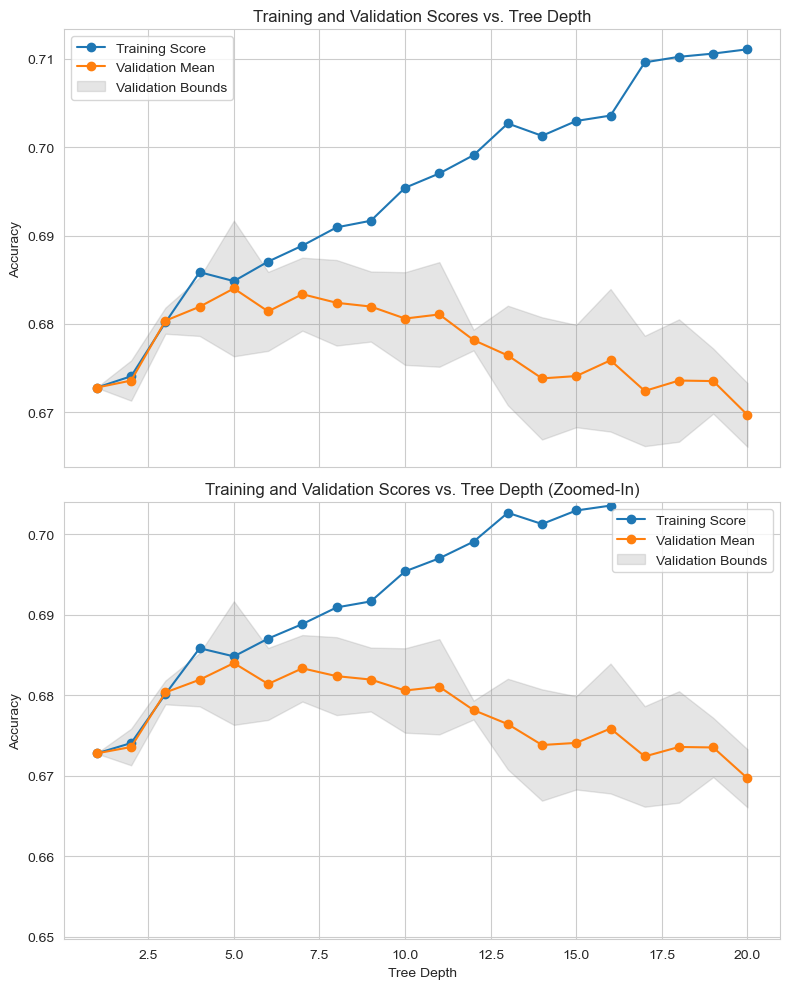

In [21]:
# Plot for both training and validation scores
fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# Plot non-cross-validation training scores
axes[0].plot(tree_depths, train_scores, label='Training Score', marker='o')

# Plot mean validation scores and haded region for +/-2 standard deviation bounds
axes[0].plot(tree_depths, cvmeans, label='Validation Mean', marker='o')
axes[0].fill_between(tree_depths, np.array(cvmeans) - 2 * np.array(cvstds),
                     np.array(cvmeans) + 2 * np.array(cvstds), color='gray', alpha=0.2, label='Validation Bounds')
# Label
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Training and Validation Scores vs. Tree Depth')
axes[0].legend()
axes[0].grid(True)

# Repeat
axes[1].plot(tree_depths, train_scores, label='Training Score', marker='o')
axes[1].plot(tree_depths, cvmeans, label='Validation Mean', marker='o')
axes[1].fill_between(tree_depths, np.array(cvmeans) - 2 * np.array(cvstds),
                     np.array(cvmeans) + 2 * np.array(cvstds), color='gray', alpha=0.2, label='Validation Bounds')

# Labels
axes[1].set_xlabel('Tree Depth')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim([min(cvmeans) - 0.02, max(cvmeans) + 0.02])  # Set y-axis limits for validation performance
axes[1].set_title('Training and Validation Scores vs. Tree Depth (Zoomed-In)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [22]:
# choose best depth after a qualitative assessment of our plots
best_cv_index = np.argmax(cvmeans)
best_cv_depth = tree_depths[best_cv_index]

best_cv_tree = DecisionTreeClassifier(max_depth=best_cv_depth, random_state=0)
best_cv_tree.fit(X_train, y_train)

best_cv_tree_train_score = best_cv_tree.score(X_train, y_train)
best_cv_tree_test_score = best_cv_tree.score(X_test, y_test)

print(
    "The tree of max-depth {} trained on the "
    "full training set, achieves the following accuracy scores:"
    "\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}".format(
        best_cv_depth,
        best_cv_tree_train_score,
        best_cv_tree_test_score,
    )
)

The tree of max-depth 5 trained on the full training set, achieves the following accuracy scores:

	train	0.6848
	TEST	0.6861


We see that our accuracy is not very high. We have yet to implement bagging or RandomForest (which we believe will be the most accurate). Let's explore why: 

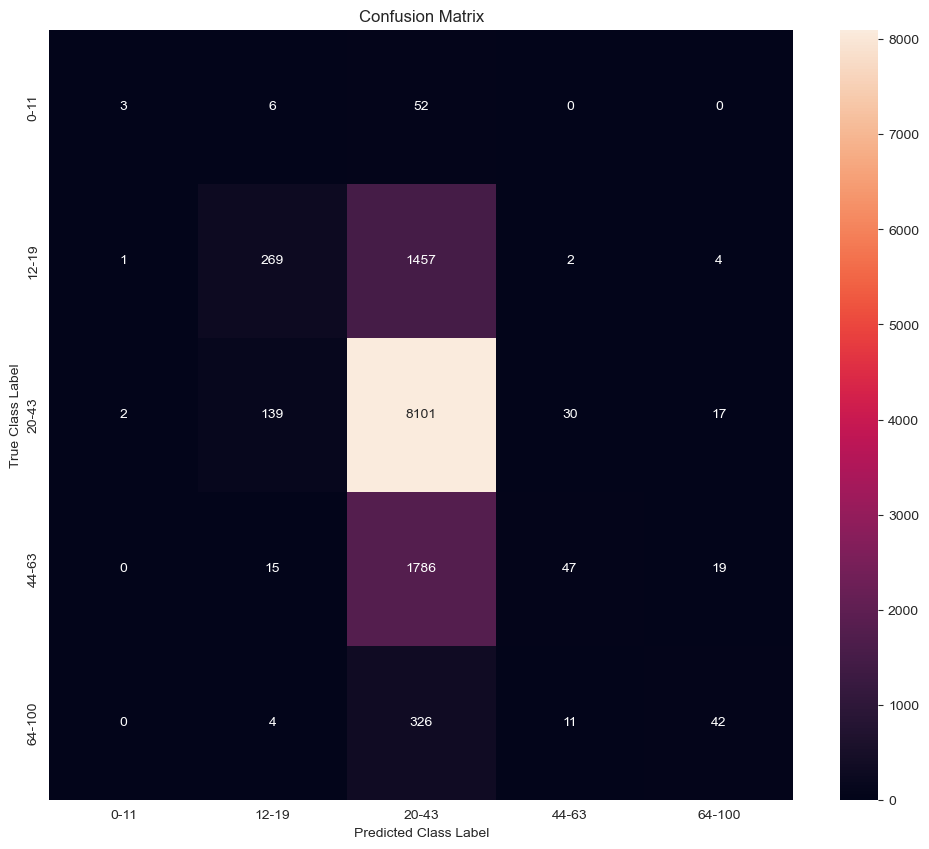

In [23]:
y_pred = best_cv_tree.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

# List of age group labels from the 'Age_Group_in_10s' column
age_group_labels = ['0-11','12-19','20-43','44-63','64-100']

# Plotting the confusion matrix with actual class labels
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='g',
            xticklabels=age_group_labels, yticklabels=age_group_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Class Label')
plt.xlabel('Predicted Class Label')
plt.show()

In the confusion matrix, we see that the numbers are particularly high in the pedicted class column for '20-43', which indicates that the model has a strong tendency to predict many instances as belonging to the '20-43' age group regardless of their true class. Adjacent age groups such as '12-19' and '44-63' are often predicted to be in age group '20-43'. Ideally, the diagonal should have higher values, as they indicate high TP and TN predictions. We will try improving our accuracy score with Bagging and Random Forest, which are supposed to be effective in this case due to their ensemble nature and ability to handle complex relationships in the data. The observed issue in the confusion matrix, where many instances are incorrectly predicted as belonging to the '20-43' age group regardless of their true class, suggests that the Decision Tree model might be overfitting or oversimplifying the data.

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for the Decision Tree
param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# Create a base Decision Tree model
dt_clf = DecisionTreeClassifier(random_state=0)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 640 candidates, totalling 3200 fits
[CV] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=20; total time=   0.2s
[CV] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5; total time=   0.2s
[CV] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10; total time=   0.2s
[CV] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=20; total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=5, min_samples_split=5; total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=5, min_samples_s

/Users/aoiotani/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
800 fits failed out of a total of 3200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
662 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/aoiotani/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/aoiotani/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/aoiotani/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py", line 638, in 

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 20}
[CV] END criterion=entropy, max_depth=None, max_features=None, min_samples_leaf=10, min_samples_split=20; total time=   0.2s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] 

<a id="part2.2"></a>
## Bagging

the optimal tree_depth in a bagging ensemble might differ from that of a single decision tree which was 5. Bagging is designed to reduce overfitting by averaging the predictions of multiple models. Each individual tree in a bagging ensemble is likely to overfit to its respective bootstrap sample, but when aggregated, these overfits can cancel each other out. This means that we could use deeper trees without overfitting as much as a single deep tree would.

In [20]:
# using function from HW 6

def bagger(
    n_trees: int,
    tree_depth: int,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    random_seed: int = 0,
) -> (pd.DataFrame, pd.DataFrame, list):
    
    # set random seed for replicable results
    np.random.seed(random_seed)
    
    # instantiate arrays and list for storing results
    bagging_train = np.zeros((X_train.shape[0], n_trees)).astype(int)
    bagging_test = np.zeros((X_test.shape[0], n_trees)).astype(int)

    bagging_models_list = []

    # perform n bootstraps
    for i in range(n_trees):
        # generate bootstrapped model
        bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
        fitted_model = DecisionTreeClassifier(
            max_depth=tree_depth,
            random_state=0
        ).fit(bootstrapped_X, bootstrapped_y)
        bagging_models_list.append(fitted_model)

        # predict on full training and test sets and store
        # results to arrays
        bagging_train[:,i] = fitted_model.predict(X_train)
        bagging_test[:,i] = fitted_model.predict(X_test)
    
    # convert arrays to pandas dataframes as required
    bagging_train_df = pd.DataFrame(
        bagging_train[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    bagging_test_df = pd.DataFrame(
        bagging_test[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    
    return bagging_train_df, bagging_test_df, bagging_models_list
    

In [47]:
best_depth = results_df.loc[results_df['Test Accuracy'].idxmax()]
print(f"The best tree depth is {best_depth['Tree Depth']} with a test accuracy of {best_depth['Test Accuracy']:.4f}.")

The best tree depth is 11.0 with a test accuracy of 0.6905.


In [28]:
n_trees = 55
tree_depth = 5
bagging_train_df, bagging_test_df, bagging_models_list  = bagger(n_trees = n_trees,
                                                                tree_depth = tree_depth,
                                                                X_train = X_train,
                                                                y_train = y_train,
                                                                X_test = X_test,
                                                                random_seed = 0)

In [29]:
bagging_train_predictions = np.mean(bagging_train_df.values, axis=1)
bagging_test_predictions = np.mean(bagging_test_df.values, axis=1)
# Calculate bagging accuracies
bagging_accuracy_train = np.mean(bagging_train_predictions == y_train)
bagging_accuracy_test = np.mean(bagging_test_predictions == y_test)

print(
    f"Bagging {n_trees} trees of depth-{tree_depth} achieves "
    f"the following accuracy scores:\n\n\ttrain\t"
    f"{bagging_accuracy_train:.4f}\n\tTEST\t"
    f"{bagging_accuracy_test:.4f}\n"
)
print(
    f"Our prior single depth-{best_cv_depth} tree achieved a "
    f"TEST score of {best_cv_tree_test_score:.4f}."
)

Bagging 55 trees of depth-5 achieves the following accuracy scores:

	train	0.6254
	TEST	0.6259



NameError: name 'best_cv_depth' is not defined

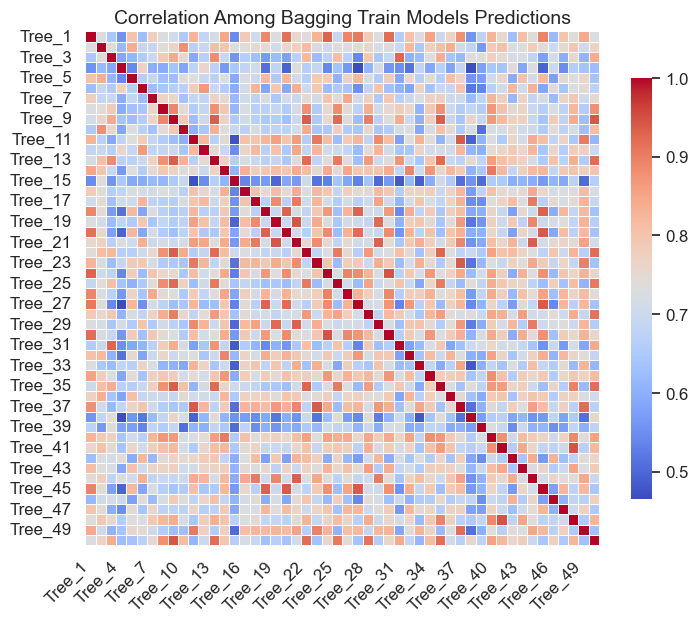

In [27]:
# Extract predictions from each base model
bagging_train_predictions_list = [bagging_train_df[col] for col in bagging_train_df.columns]
bagging_test_predictions_list = [bagging_test_df[col] for col in bagging_test_df.columns]

# Create DataFrames for individual base model predictions
bagging_train_predictions_df = pd.DataFrame({f'Tree_{i+1}': predictions for i, predictions in enumerate(bagging_train_predictions_list)})
bagging_test_predictions_df = pd.DataFrame({f'Tree_{i+1}': predictions for i, predictions in enumerate(bagging_test_predictions_list)})

# Calculate the correlation matrices
correlation_matrix_train = bagging_train_predictions_df.corr()
correlation_matrix_test = bagging_test_predictions_df.corr()

plt.figure(figsize=(14, 6))
sns.set(font_scale=1.1)  

plt.subplot(1, 2, 1)
sns.heatmap(
    correlation_matrix_train,
    annot=False,
    cmap='coolwarm',
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8},
)
plt.title('Correlation Among Bagging Train Models Predictions', fontsize=14)
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0) 
plt.tight_layout()

plt.show()

The bagging approach yielded a lower accuracy scores for both the training and test datasets, a surprising outcome upon initial assessment. Closer examination of the dataset revealed the presence of multiple missing values (in two of the columns as listed in the summary previously), potentially leading to increased correlation among the bootstrapped decision trees. The susceptibility of bagging to poor performance is notable in scenarios where the base models (trees) exhibit high correlation, as is evident in our dataset and shown on the corrrelation map above. Given the intricate interactions and high dimensionality of our dataset, the introduction of randomness in the random forest approach may be better aligned with its inherent complexities.

<a id="part2.3"></a>
## Random Forest

To use RandomForestClassifier, we cannot have any missing data. From our current dataset, we have two columns with missing data. Note that this method will not yeild a direct comparison because the data will have to be resplit.

### Method 1: Remove rows with missing data

In [28]:
df_copy = df.copy()
df_copy.dropna(inplace=True)
print(f"Our data contains {len(df_copy):,} samples.")

print("DATA INFORMATION:\n")
df_copy.info()

Our data contains 19,600 samples.
DATA INFORMATION:

<class 'pandas.core.frame.DataFrame'>
Index: 19600 entries, 0 to 61660
Data columns (total 62 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   n_killed                       19600 non-null  int64   
 1   n_injured                      19600 non-null  int64   
 2   congressional_district         19600 non-null  category
 3   state_house_district           19600 non-null  float64 
 4   Victim_average_age             19600 non-null  float64 
 5   Subject-Suspect_gender_binary  19600 non-null  int64   
 6   year                           19600 non-null  int64   
 7   month                          19600 non-null  int64   
 8   Age_Group_Code                 19600 non-null  int64   
 9   state_house_district	          19600 non-null  category
 10  state_Alabama                  19600 non-null  bool    
 11  state_Alaska                   19600 non-null

In [29]:
# resplit data 
X_1 = df_copy.drop('Age_Group_Code', axis=1)  # Features
y_1 = df_copy['Age_Group_Code']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=109)

In [30]:
# decision tree
tree_depths = list(range(1, 21))
train_scores = []
cvmeans = []
cvstds = []

for depth in tree_depths:
    # Fit a decision tree and evaluate on the entire training set
    clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    train_scores.append(train_score)

    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    cvmeans.append(np.mean(cv_scores))
    cvstds.append(np.std(cv_scores))

In [31]:
best_cv_index = np.argmax(cvmeans)
best_cv_depth = tree_depths[best_cv_index]

best_cv_tree = DecisionTreeClassifier(max_depth=best_cv_depth, random_state=0)
best_cv_tree.fit(X_train, y_train)

best_cv_tree_train_score = best_cv_tree.score(X_train, y_train)
best_cv_tree_test_score = best_cv_tree.score(X_test, y_test)

print(
    "The tree of max-depth {} trained on the "
    "full training set, achieves the following accuracy scores:"
    "\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}".format(
        best_cv_depth,
        best_cv_tree_train_score,
        best_cv_tree_test_score,
    )
)

The tree of max-depth 4 trained on the full training set, achieves the following accuracy scores:

	train	0.6732
	TEST	0.6704


In [32]:
n_trees = 50
tree_depth = best_cv_depth
bagging_train_df, bagging_test_df, bagging_models_list  = bagger(n_trees = n_trees,
                                                                tree_depth = tree_depth,
                                                                X_train = X_train,
                                                                y_train = y_train,
                                                                X_test = X_test,
                                                                random_seed = 0)

In [33]:
# Finally, we can use RandomForest
random_forest_classifier = RandomForestClassifier(
    n_estimators = n_trees,
    max_depth = tree_depth,
    max_features = 'sqrt',  # Square root of the total number of features
    random_state = 109
)
random_forest_classifier.fit(X_train, y_train)

random_forest_train_score = random_forest_classifier.score(X_train, y_train)
random_forest_test_score = random_forest_classifier.score(X_test, y_test)

print(f"Random Forest Train Accuracy: {random_forest_train_score:.4f}")
print(f"Random Forest Test Accuracy: {random_forest_test_score:.4f}")

Random Forest Train Accuracy: 0.6320
Random Forest Test Accuracy: 0.6293


Reducing our dataset from 61,000 to 19,000 instances resulted in lower accuracy scores, highlighting the impact of dataset size on predictive performance. Surprisingly, even with the ensemble approach of Random Forest, we didn't observe the expected improvement in accuracy. This discrepancy emphasizes the challenges introduced by the reduced dataset size and raises questions about the adaptability of ensemble methods to such scenarios. Further investigation into factors like hyperparameter tuning is warranted to explore avenues for enhancing predictive accuracy in the context of significantly reduced data size. Reducing the dataset increases its simplicity.

### Method 2: Remove the columns with missing data

In [34]:
df.columns = df.columns.str.strip()
columns_to_drop = ['state_house_district', 'Victim_average_age']
new_df = df.drop(columns=columns_to_drop)

In [35]:
print(f"Our data contains {len(new_df):,} samples.")

print("DATA INFORMATION:\n")
new_df.info()

Our data contains 61,661 samples.
DATA INFORMATION:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61661 entries, 0 to 61660
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   n_killed                       61661 non-null  int64   
 1   n_injured                      61661 non-null  int64   
 2   congressional_district         61661 non-null  category
 3   Subject-Suspect_gender_binary  61661 non-null  int64   
 4   year                           61661 non-null  int64   
 5   month                          61661 non-null  int64   
 6   Age_Group_Code                 61661 non-null  int64   
 7   state_Alabama                  61661 non-null  bool    
 8   state_Alaska                   61661 non-null  bool    
 9   state_Arizona                  61661 non-null  bool    
 10  state_Arkansas                 61661 non-null  bool    
 11  state_California               61661 non

In [36]:
X_2 = new_df.drop('Age_Group_Code', axis=1)  # Features
y_2 = new_df['Age_Group_Code']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=109)

In [37]:
tree_depths = list(range(1, 21))
train_scores = []
cvmeans = []
cvstds = []

for depth in tree_depths:

    # Fit a decision tree and evaluate on the entire training set
    clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    train_scores.append(train_score)

    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    cvmeans.append(np.mean(cv_scores))
    cvstds.append(np.std(cv_scores))

In [38]:
best_cv_index = np.argmax(cvmeans)
best_cv_depth = tree_depths[best_cv_index]

best_cv_tree = DecisionTreeClassifier(max_depth=best_cv_depth, random_state=0)
best_cv_tree.fit(X_train, y_train)

best_cv_tree_train_score = best_cv_tree.score(X_train, y_train)
best_cv_tree_test_score = best_cv_tree.score(X_test, y_test)

print(
    "The tree of max-depth {} trained on the "
    "full training set, achieves the following accuracy scores:"
    "\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}".format(
        best_cv_depth,
        best_cv_tree_train_score,
        best_cv_tree_test_score,
    )
)

The tree of max-depth 1 trained on the full training set, achieves the following accuracy scores:

	train	0.6728
	TEST	0.6721


In [39]:
n_trees = 50
tree_depth = best_cv_depth
bagging_train_df, bagging_test_df, bagging_models_list  = bagger(n_trees = n_trees,
                                                                tree_depth = tree_depth,
                                                                X_train = X_train,
                                                                y_train = y_train,
                                                                X_test = X_test,
                                                                random_seed = 0)

In [40]:
random_forest_classifier = RandomForestClassifier(
    n_estimators = n_trees,
    max_depth = tree_depth,
    max_features = 'sqrt',  # Square root of the total number of features
    random_state = 0
)
random_forest_classifier.fit(X_train, y_train)

random_forest_train_score = random_forest_classifier.score(X_train, y_train)
random_forest_test_score = random_forest_classifier.score(X_test, y_test)

print(f"Random Forest Train Accuracy: {random_forest_train_score:.4f}")
print(f"Random Forest Test Accuracy: {random_forest_test_score:.4f}")

Random Forest Train Accuracy: 0.6728
Random Forest Test Accuracy: 0.6721


Instead of curbing data, we eliminated two variables in our analysis, revealing a noteworthy insight - the observation indicates that a depth of 1 is optimal, suggesting that our dataset's limited number of variables poses challenges for effective modeling when utilizing a subset of those variables, even if the dataset retains its original size, around 61,000. The inclination toward a shallower tree structure implies a preference for a more simplistic model. This revelation prompts contemplation on the dataset's intricate nature and underscores the delicate balance between model complexity and the quantity of information essential for accurate predictions. 

### Method 3: Remove rows with missing data

### Correlation of data
We initially assumed that the trees were correlated, but the results of the RandomForest asks us to revisit the features and the importance they hold in determining the age group.

In [41]:
combined_data = pd.concat([X_train_copy, y_train_copy], axis=1)
correlation_values = combined_data.corrwith(y_train_copy)
top_5 = correlation_values.abs().nlargest(5)
display(top_5)

Age_Group_Code                   1.000000
Victim_average_age               0.466994
city_or_county_freq              0.118370
n_killed                         0.112829
Subject-Suspect_gender_binary    0.065636
dtype: float64

Upon reviewing the outcomes presented, which we briefly explored during EDA, it becomes evident that the column "Victim_average_age," previously excluded, exhibits notably high feature importance and would thus obviously harm the predictive model if removed. However, the utilization of RandomForest is constrained by its requirement of a dataset devoid of NaN values. In light of this constraint, RandomForest proves unsuitable for our specific objective. While contemplating the prospect of imputing missing values, the sheer volume of rows with absent "Victim_average_age" entries raises concerns about potential data imbalances that such imputation might introduce.

<a id="part2final"></a>
## Final Model

For the final model pipeline, we have decided to use the Decision Tree as the final model. This decision is based on several key observations and considerations regarding the dataset and our project's goal. Firstly, the Decision Tree model achieved a higher score compared to more complex ensemble methods like Bagging and Random Forest. While this outcome was unexpected, it suggests that our dataset was relatively straightforward, with crucial patterns that can be effectively captured with simple decision splits.

Furthermore, the dataset seems to contain a few highly predictive features, which a Decision Tree can utilize efficiently. In contrast, the random feature selection in ensemble methods might overlook these key features in some models. Moreover, the dataset contained many missing values, which meant that rows with missing values had to be removed for Random Forest, significantly reducing the dataset's size. The inherent capability of Decision Trees to manage missing data effectively was particularly beneficial.

For our final submission, we will optimize the decision tree to better optimize the dataset and output.